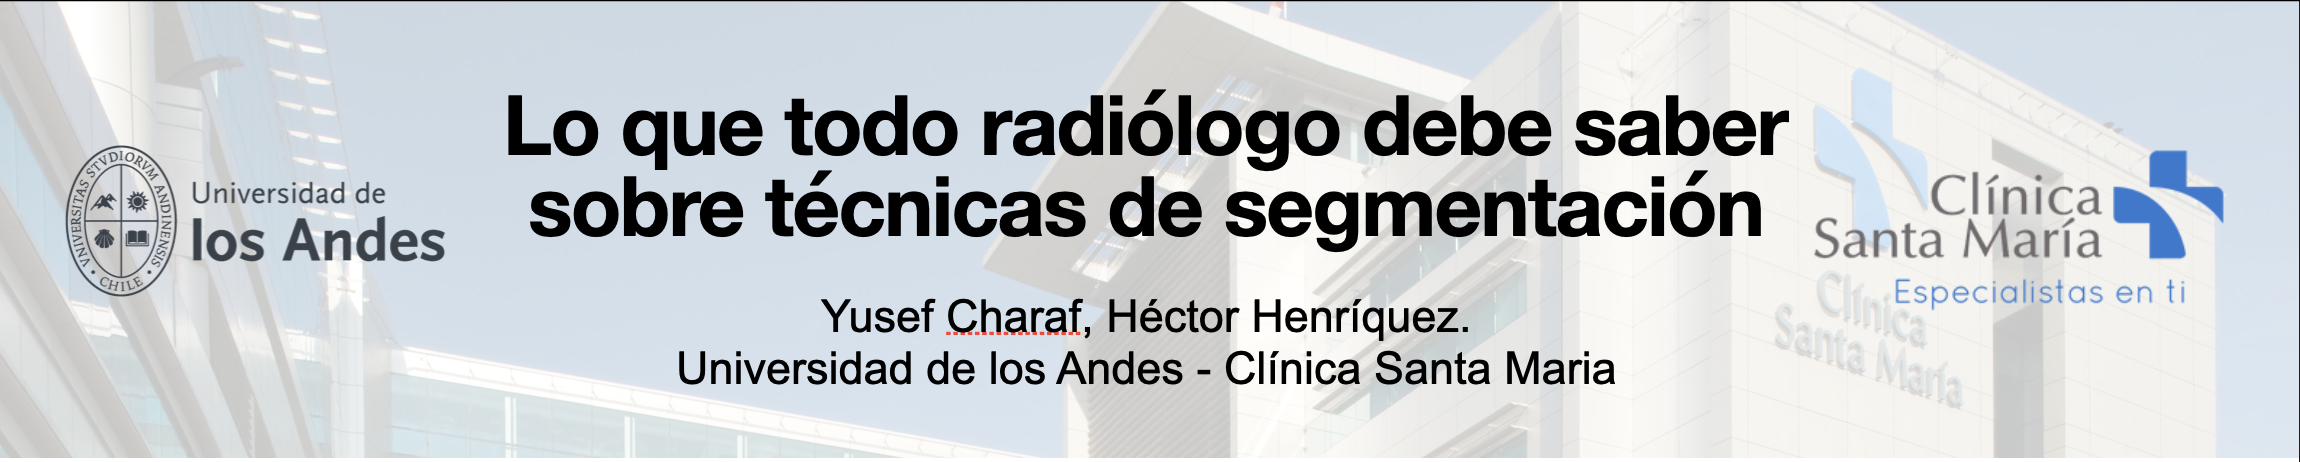

* Autor: Héctor Henríquez Leighton.
* Colaborador: Yusef Charaf
* E-Mail: hhenriquez@miuandes.cl

In [ ]:
! pip install seg_metrics

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, f1_score, jaccard_score
from mpl_toolkits import mplot3d
import seg_metrics.seg_metrics as sg
from plotnine import *

import warnings
warnings.filterwarnings("ignore")

In [28]:
## Ajuste de contraste de las imágenes
def show_slice_window(slice, level, window):
    """
    Función para ajustar el contraste de las imágenes.
    Input: recibe imagen como array 2D, el nivel y ancho de ventana.
    Output: imagen ajustada
   """
    max = level + window/2
    min = level - window/2
    slice = slice.clip(min,max)
    return(slice)


def rotateMask(mask):
    """
    Función que permite ajustar la rotación de las imágenes.
    Rotación predefinida para ajustar las imágenes usadas en este notebook
    """
    maskRot = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
    maskRot = cv2.flip(maskRot,1)
    return(maskRot)
    

## Descarga las imágenes desde Google Drive:
https://drive.google.com/file/d/1igN2WT-6iRuAnvcHQUM4MhgLIrZnnZZo/view?usp=sharing

In [10]:
## Carga de imágenes
all_images = np.load('tensor_segmentacion.npy', allow_pickle = True)
print(all_images.shape)

(14,)


## Introducción:
La segmentación de imágenes médicas es una técnica cada vez más utilizada, debido a que es el proceso fundamental que permite la **medición del volumen de órganos o tumores**, además de servir para generar la extracción de áreas de interés en una imagen para su posterior **análisis cuantitativo** o bien para la generación de **modelos de impresión 3D**. En general corresponde a una tarea repetitiva y muy demandante de tiempo. Es por esto, que se han desarrollado múltiples técnicas semiautomáticas y automáticas que intentan resolver esta tarea, lo que se ha visto reflejado en un aumento exponencial en el número de publicaciones científicas en los últimos años. El uso de Deep Learning ha determinado una importante mejoría en el rendimiento de las herramientas de segmentación. La evaluación de modelos de segmentación requiere la comprensión de algunas métricas que son menos conocidas por la mayoría de los radiólogos [1-2-3]. 

Objetivos: Los objetivos de este trabajo son dar a conocer los principios básicos de la segmentación de imágenes, enseñar las principales métricas de evaluación que se ocupan en tareas de segmentación, sus ventajas y desventajas. 

## Definición:

La segmentación corresponde al proceso de separar una imagen en múltiples regiones que comparten algún elemento en común. Por ejemplo, pixeles que pertenecen todos al mismo tumor u órgano, o pixeles que representan el mismo tipo de tejido (grasa).

Figura 1. Segmentación de áreas de neumonía en radiografía de tórax.

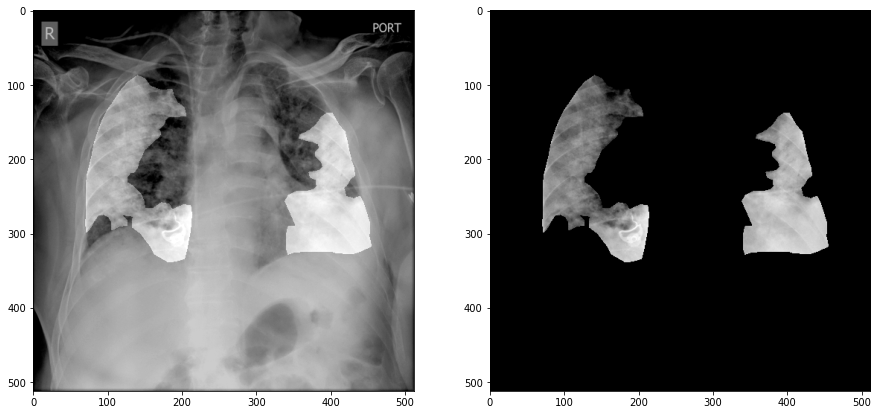

In [12]:

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.imshow(all_images[0], cmap='gray')

f.add_subplot(1, 2, 2)
plt.imshow(all_images[1], cmap='gray')
plt.show()

## Técnica:
El proceso de segmentación de un objeto implica la delimitación de su contorno, con el propósito de crear una máscara de segmentación, la que define cuáles pixeles corresponden a la región de interés (ROI).

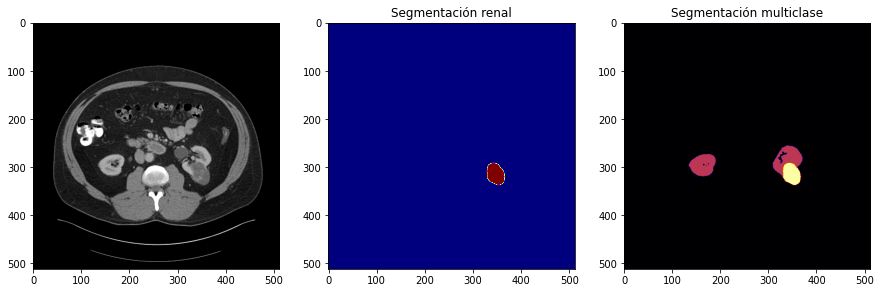

In [13]:

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 3, 1)
plt.imshow(show_slice_window(all_images[10], 50,400), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title('Segmentación renal')
plt.imshow(np.where(all_images[11] == 2, 1, 0), cmap='jet')

f.add_subplot(1, 3, 3)
plt.title('Segmentación multiclase')
plt.imshow(all_images[11], cmap='inferno')
plt.show()


## Máscaras de Segmentación
Corresponde a una matriz, habitualmente binaria (0 y 1), cuyos valores 1 representan los pixeles de interés en la imagen.

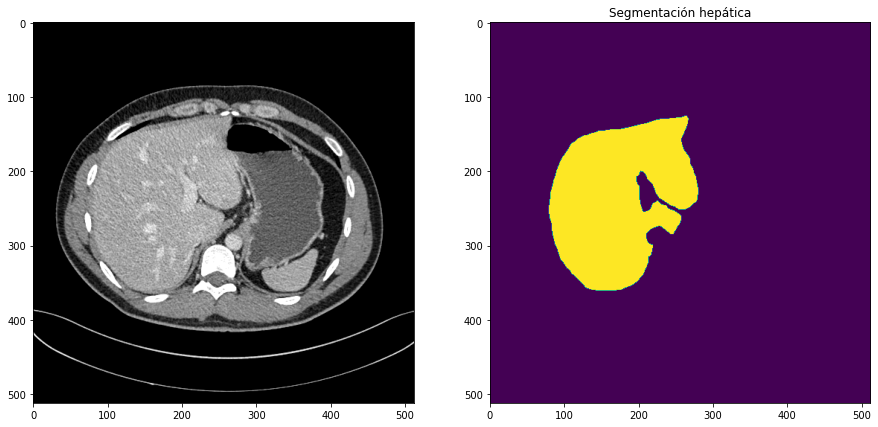

In [14]:
f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.imshow(show_slice_window(all_images[4], 50,400), cmap='gray')

f.add_subplot(1, 2, 2)
plt.title('Segmentación hepática')
plt.imshow(all_images[5], cmap='viridis')
plt.show()

In [15]:
## Se redimensiona la imagen para mejor visualización como dataframe
dim = 40,35

df = pd.DataFrame(cv2.resize(all_images[5], dim,
               interpolation = cv2.INTER_NEAREST))

df_styled = df.style.background_gradient()
df_styled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Máscaras multiclase
En los problemas que son multiclase (es decir, existe más de un objeto de interés en la imagen) las máscaras pueden tomar mas de dos valores.

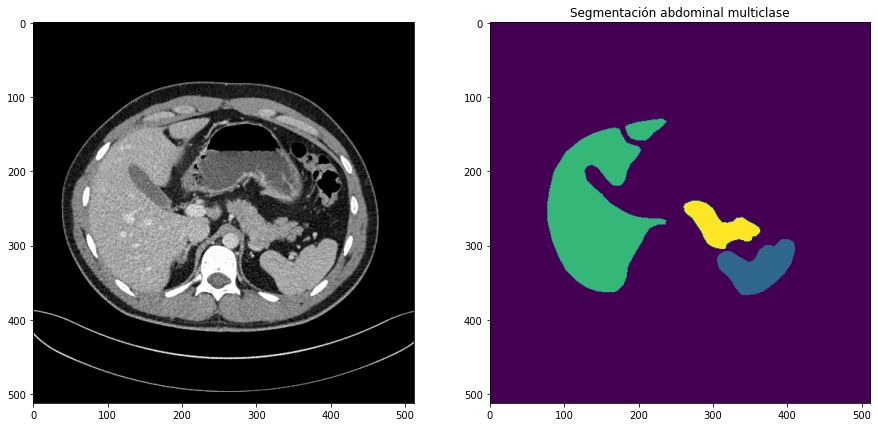

In [17]:
f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.imshow(show_slice_window(all_images[6], 50,400), cmap='gray')

f.add_subplot(1, 2, 2)
plt.title('Segmentación abdominal multiclase')
plt.imshow(all_images[7], cmap='viridis')
plt.show()

In [18]:
## Se redimensiona la imagen para mejor visualización como dataframe
dim = 40,35
df = pd.DataFrame(cv2.resize(all_images[7], dim,
               interpolation = cv2.INTER_NEAREST))

df_styled2 = df.style.background_gradient()
df_styled2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Nomenclatura

Las máscaras de segmentación realizadas por un operador experimentado corresponden al estándar de referencia y se conocen como **Ground Truth (GT)**. 


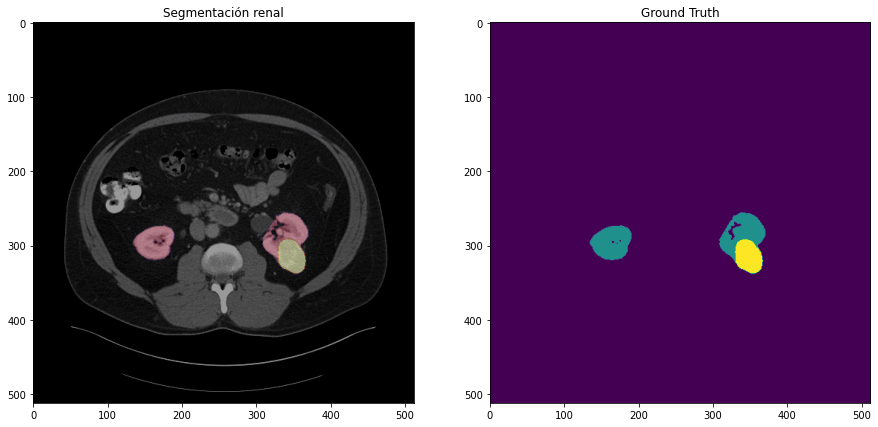

In [19]:
f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.title('Segmentación renal')
plt.imshow(show_slice_window(all_images[10], 50,400), cmap='gray')
plt.imshow(all_images[11], cmap='inferno', alpha=0.4)


f.add_subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(all_images[11], cmap='viridis')
plt.show()

## Evaluación:
La segmentación de imágenes corresponde a un problema de clasificación, en el cual se deben identificar correctamente los pixeles que corresponden al objeto de interés (órgano o lesión). Al evaluar un modelo que realiza segmentación automática debemos tener en consideración diferentes tipos de métricas. La selección de alguna de ellas va a depender específicamente del tipo problema y características de la imagen. 

## Clasificación de los pixeles:

* Verdadero Positivo (VP): Pixeles del objeto correctamente clasificados. Corresponden a la intersección entre GT y Predicción.
* Verdadero Negativo (VN): Pixeles correctamente clasificados como fondo.
* Falso Negativo (FN): Pixeles del objeto en el Ground Truth clasificados incorrectamente como fondo en la Predicción:
* Falso Positivo (FP): Pixeles del fondo clasificados como positivos en la predicción.

### *La utilización incorrecta de métricas de clasificación puede llevar a resultados que aparentan una alta calidad predictiva, pero que en la práctica se correlacionan con mal desempeño clínico.*

## Métricas

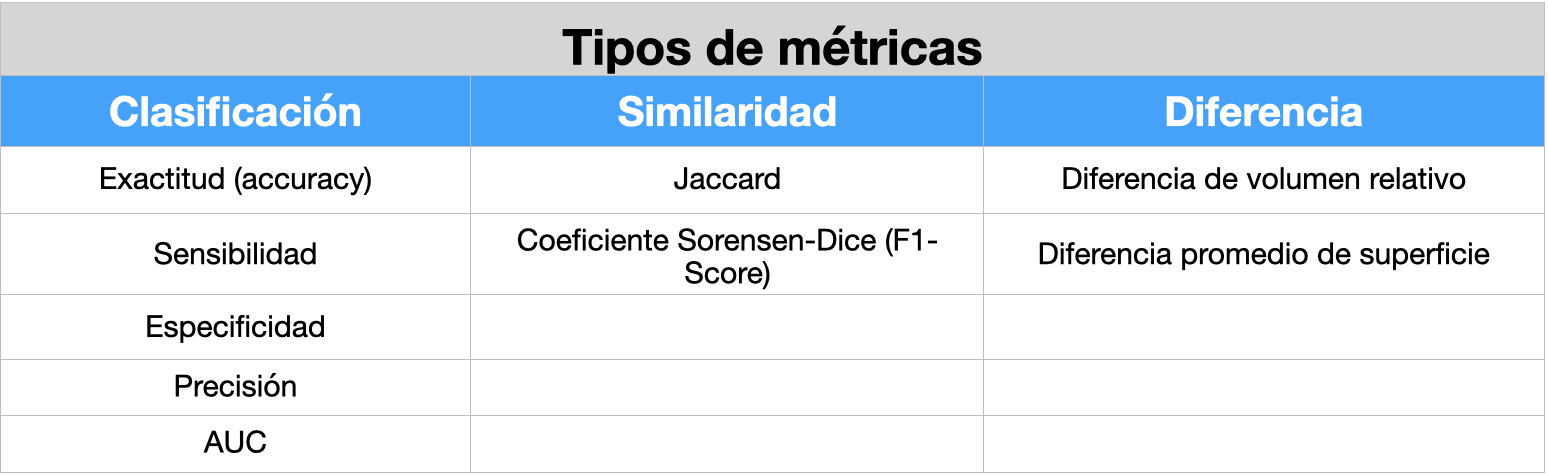


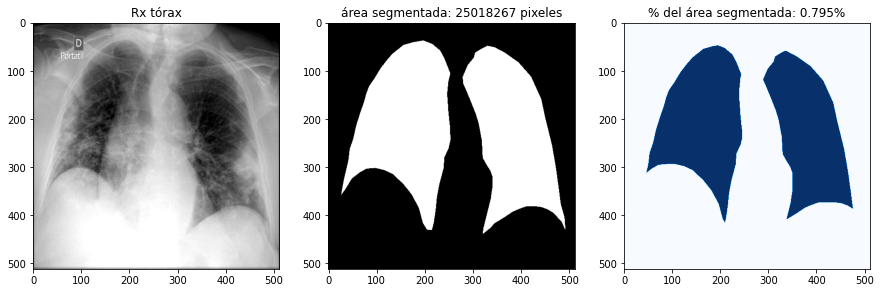

In [20]:
## Se erosionan las máscaras pulmonares para generar una nueva segmentación.

## tamaño de kernel
kernel = np.ones((17,17))

lungSegErode = cv2.erode(all_images[3], kernel)

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 3, 1)
plt.title('Rx tórax')
plt.imshow(show_slice_window(all_images[2], 50,400), cmap='gray')

f.add_subplot(1, 3, 2)
plt.title('área segmentada: {} pixeles'.format(all_images[3].sum()))
plt.imshow(all_images[3], cmap='gray')

f.add_subplot(1, 3, 3)
plt.title('% del área segmentada: {}%'.format(round(lungSegErode.sum() / all_images[3].sum(),3)))
plt.imshow(lungSegErode, cmap='Blues')

plt.show()

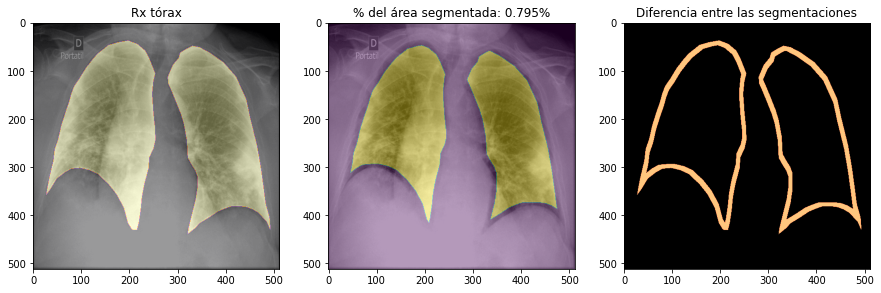

In [21]:

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 3, 1)
plt.title('Rx tórax')
plt.imshow(show_slice_window(all_images[2], 50,400), cmap='gray')
plt.imshow(all_images[3], cmap='inferno', alpha=0.4)


f.add_subplot(1, 3, 2)
plt.title('% del área segmentada: {}%'.format(round(lungSegErode.sum() / all_images[3].sum(),3)))
plt.imshow(show_slice_window(all_images[2], 50,400), cmap='gray')
plt.imshow(lungSegErode, cmap='viridis', alpha=0.4)

f.add_subplot(1, 3, 3)
plt.title('Diferencia entre las segmentaciones')
plt.imshow(all_images[3] - lungSegErode, cmap='copper')

plt.show()

## Exactitud

* La exactitud evalúa los pixeles correctamente clasificados sobre el total de pixeles.

$ accuracy = \frac{VP + VN}{VP + VN + FN + FP}$


Accuracy: 0.923


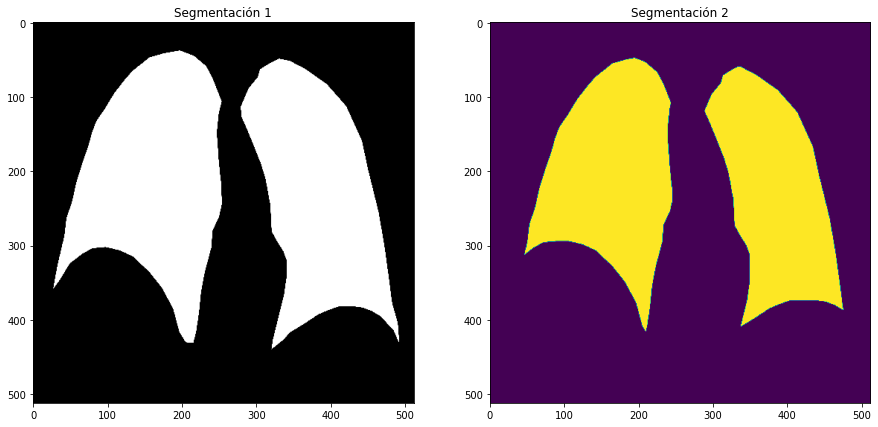

In [22]:
## Se llevan a arreglos binarios
segUnoBin = np.where(all_images[3] == 255 ,1,0)
segDosBin = np.where(lungSegErode == 255,1,0)

## Cálculos de métricas
print("\nAccuracy:", round(accuracy_score(segUnoBin.flatten(), segDosBin.flatten()),3))

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.title('Segmentación 1')
plt.imshow(all_images[3], cmap='gray')

f.add_subplot(1, 2, 2)
plt.title('Segmentación 2')
plt.imshow(lungSegErode, cmap='viridis')

## Imagen volumétrica: Tumor pulmonar

In [23]:
## carga de imagen volumétrica de cáncer pulmonar
lung_tumor = all_images[12]
lung_tumor_mask = all_images[13]

print("Dimensiones imagen volumétrica pumlmonar:", lung_tumor.shape)
print("Dimensiones máscaras:", lung_tumor_mask.shape)

Dimensiones imagen volumétrica pumlmonar: (37, 512, 512)
Dimensiones máscaras: (37, 512, 512)


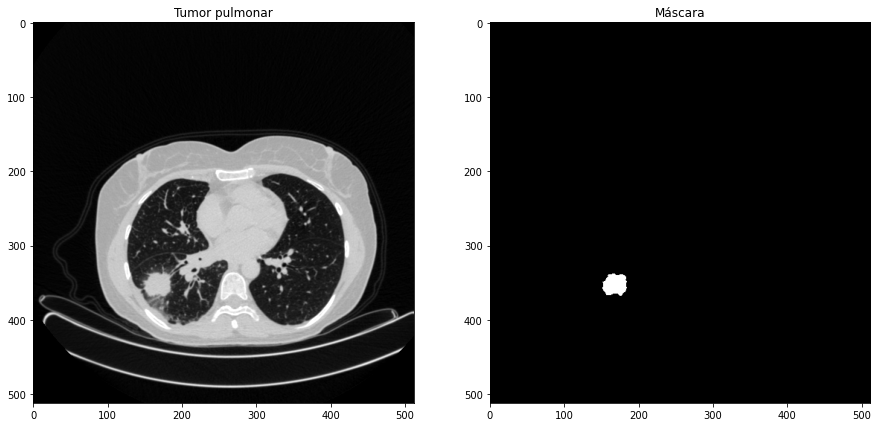

In [29]:

imagen = 15
level = -400
window_width = 1500


f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.title('Tumor pulmonar')
plt.imshow(show_slice_window(rotateMask(lung_tumor[imagen]), level,window_width), cmap='gray')


f.add_subplot(1, 2, 2)
plt.title('Máscara')
plt.imshow(rotateMask(lung_tumor_mask[imagen]), cmap='gray')

plt.show()

## El problema del desbalance de Clases:
Frecuentemente la cantidad de pixeles de la segmentación corresponde a una proporción muy baja de la imagen total. Esto se conoce como **desbalance de clases.**

pixeles negros: 261373
pixeles blancos: 771
********************************************************************** 
Porcentaje de pixeles blancos: 0.29%
**********************************************************************


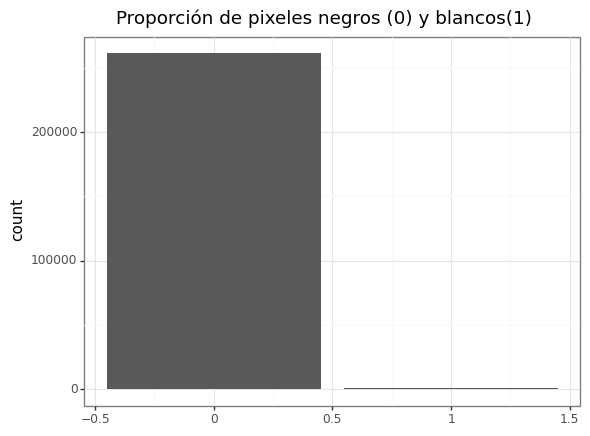

<ggplot: (8754199296145)>

In [30]:
print("pixeles negros: 261373")
print("pixeles blancos: 771")
print("**"*35,"\nPorcentaje de pixeles blancos: {}%".format(round((lung_tumor_mask[imagen].sum() / lung_tumor_mask[imagen].flatten().shape[0])*100,2)))
print("**"*35)

(
ggplot() + 
    aes(x=lung_tumor_mask[imagen].flatten())+
    geom_bar() +
    theme_bw() +
    labs(title='Proporción de pixeles negros (0) y blancos(1)')
)



* En las segmentaciones de lesiones pequeñas, la exactitud y la especificidad tienden a exacerbar la calidad predictiva, con métricas elevadas debido a la alta proporción de pixeles negros.
* Imaginemos una predicción de un modelo que es una máscara completamente negra. Vale decir, el modelo no logró predecir nada.
* Llamaremos a esta predicción: Predicción nula

Podemos ver que accuracy es prácticamente 1 (100%), 
y el modelo realmente NO HIZO NADA!!!

Accuracy: 0.9970588684082031
******************************************************************************************


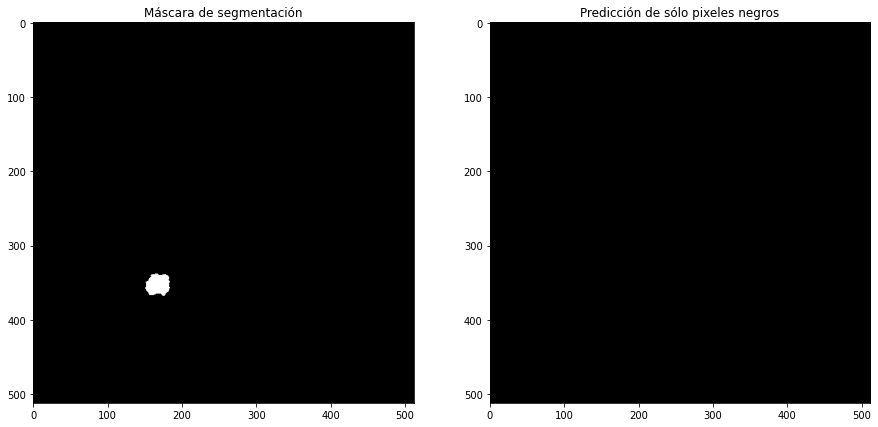

In [33]:
prediccion_nula = np.zeros((lung_tumor_mask[imagen].shape))

print("Podemos ver que accuracy es prácticamente 1 (100%), \ny el modelo realmente NO HIZO NADA!!!")

print("\nAccuracy:", accuracy_score(lung_tumor_mask[imagen].flatten(), prediccion_nula.flatten()))

print('**'*45)

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.title('Máscara de segmentación')
plt.imshow(rotateMask(lung_tumor_mask[imagen]), cmap='gray')


f.add_subplot(1, 2, 2)
plt.title('Predicción de sólo pixeles negros')
plt.imshow(prediccion_nula, cmap='gray')

plt.show()

## Revisemos otras métricas en este caso fuertemente desbalanceado

* Podemos ver que el recall de la clase 0 (pixeles negros), es prácticamente 1. Esto corresponde a la detección de pixeles negros sobre el total de pixeles negros...dicho de otro modo, en este caso corresponde a la ESPECIFICIDAD.
* La precisión de pixeles negros obviamente también alcanza valor de 1

$ especificidad = \frac{VN}{VN + FP}$

$ precision = \frac{VP}{VP + FP}$


In [35]:
print(classification_report(lung_tumor_mask[imagen].flatten(), prediccion_nula.flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    261373
           1       0.00      0.00      0.00       771

    accuracy                           1.00    262144
   macro avg       0.50      0.50      0.50    262144
weighted avg       0.99      1.00      1.00    262144



## Sensibilidad

La sensibilidad corresponde a la proporción de pixeles del objeto correctamente clasificados, sobre la totalidad de los pixeles del objeto.

$ recall (sensibilidad) = \frac{VP}{VP + FN}$


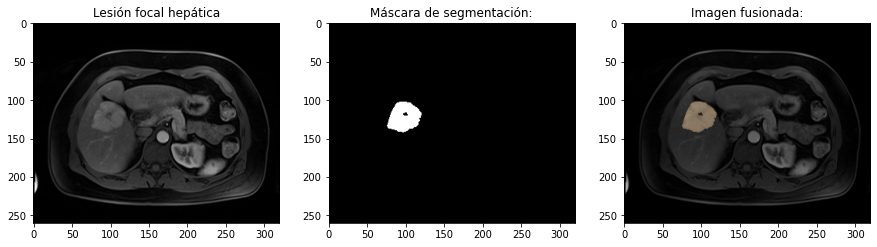

In [36]:

liver_tumor = rotateMask(all_images[8])
liver_tumor_mask = rotateMask(all_images[9])


f = plt.figure(figsize=(15,15))

f.add_subplot(1, 3, 1)
plt.title('Lesión focal hepática')
plt.imshow(liver_tumor, cmap='gray')


f.add_subplot(1, 3, 2)
plt.title('Máscara de segmentación:')
plt.imshow(liver_tumor_mask, cmap='gray')

f.add_subplot(1, 3, 3)
plt.title('Imagen fusionada:')
plt.imshow(liver_tumor, cmap='gray')
plt.imshow(liver_tumor_mask, cmap='copper', alpha=0.3)

plt.show()

## Crearemos una segmentación que simule la predicción de un modelo que genere una imagen sobresegmentada (de mayor tamaño que el tumor)

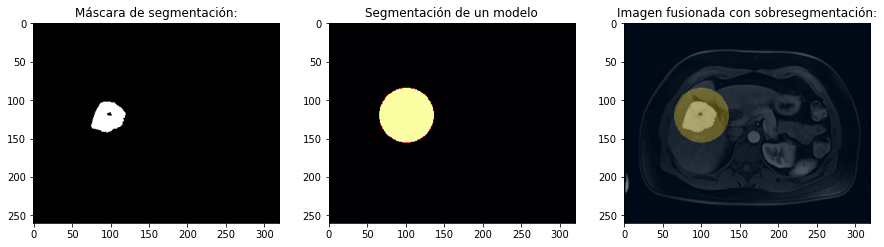

In [38]:
black_image = np.zeros((liver_tumor_mask.shape[0],liver_tumor_mask.shape[1] ))


radius = 15
color = (255, 0, 0)
thickness = 40

superseg_image = cv2.circle(black_image, (100,120), radius, color, thickness)

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 3, 1)
plt.title('Máscara de segmentación:')
plt.imshow(liver_tumor_mask, cmap='gray')


f.add_subplot(1, 3, 2)
plt.title('Segmentación de un modelo')
plt.imshow(superseg_image, cmap='inferno')

f.add_subplot(1, 3, 3)
plt.title('Imagen fusionada con sobresegmentación:')
plt.imshow(liver_tumor, cmap='gray')
plt.imshow(liver_tumor_mask, cmap='gray',alpha=0.3)
plt.imshow(superseg_image, cmap='cividis', alpha=0.3)

plt.show()

La imagen muestra una segmentación de un modelo fusionado con el Ground Truth, en la cual existe una sobresegmentación. En este caso tendremos una sensibilidad del 100% debido a que todos los pixeles del objeto están seleccionados. Sin embargo, existen muchos falsos positivos que no son penalizados.

* Podemos ver que el Recall de la clase 1, o sea la Sensibilidad de la segmentación, alcanza 1.

In [39]:
print(classification_report(liver_tumor_mask.flatten(), np.where(superseg_image == 255,1,0).flatten()))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     81942
           1       0.32      1.00      0.48      1258

    accuracy                           0.97     83200
   macro avg       0.66      0.98      0.73     83200
weighted avg       0.99      0.97      0.98     83200



## Coeficiente de Dice

* Coeficiente de Dice o indice de traslape, evalúa  la proporción entre la intersección de GT y predicción, sobre la sumatoria de GT y Predicción.
Es equivalente al F1-Score en problemas binarios.

$ Dice = \frac{2 (GT\bigcap Pred)}{GT + Pred} =  \frac{2VP}{2VP + FN + FP} $

Es una métrica muy utilizada en problemas de segmentación, junto al score de Jaccard. Captura la coincidencia de pixeles entre la predicción y el Ground Truth. No considera los verdaderos negativos. 

$ Jaccard = \frac{Dice}{2 - Dice}$

Calculemos las métricas que conocemos hasta ahora en este problema:

Accuracy: 0.9504
Sensibilidad: 0.594
Especificidad: 1.0
Dice  (F1 score): 0.7453
Jaccard score: 0.7703


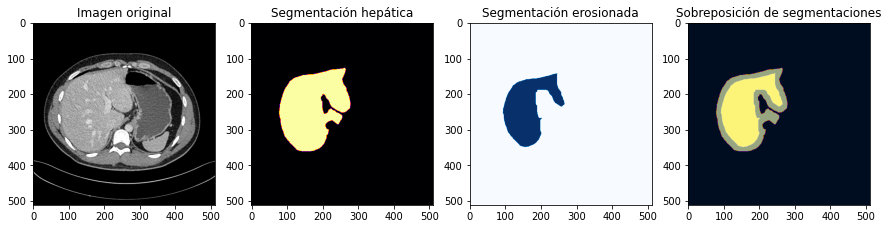

In [40]:
## Crearemos una segmentación nueva del higado, generando una erosión de la máscara original

liver_img = show_slice_window(all_images[4], 50,400)
liver_mask_original = all_images[5]

## Erosión:
kernel = np.ones((13,13))
liver_mask_eroded = cv2.erode(liver_mask_original, kernel, iterations=2)


print("Calculemos las métricas que conocemos hasta ahora en este problema:\n")
print("Accuracy:", round(accuracy_score(liver_mask_original.flatten(), liver_mask_eroded.flatten()),4))
print("Sensibilidad:", round(recall_score(liver_mask_original.flatten(), liver_mask_eroded.flatten()),4))
print("Especificidad:", round(recall_score(liver_mask_original.flatten(), liver_mask_eroded.flatten(),pos_label=0),4))
print("Dice  (F1 score):", round(f1_score(liver_mask_original.flatten(), liver_mask_eroded.flatten(),pos_label=1),4))
print("Jaccard score:",round(jaccard_score(liver_mask_original.flatten(), liver_mask_eroded.flatten(), average='macro'),4))

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 4, 1)
plt.title('Imagen original')
plt.imshow(liver_img, cmap='gray')

f.add_subplot(1, 4, 2)
plt.title('Segmentación hepática')
plt.imshow(liver_mask_original, cmap='inferno')

f.add_subplot(1, 4, 3)
plt.title('Segmentación erosionada')
plt.imshow(liver_mask_eroded, cmap='Blues')

f.add_subplot(1, 4, 4)
plt.title('Sobreposición de segmentaciones')
plt.imshow(liver_mask_original, cmap='inferno')
plt.imshow(liver_mask_eroded, cmap='cividis', alpha=0.4)

plt.show()


## Evaluación de imagen volumétrica
* Debido a que el tumor ocupa una parte muy pequeña de la imagen, se utiliza un ROI basado en las coordenadas de la segmentación

In [41]:
all_mask = []
all_img = []

for i in range(lung_tumor_mask.shape[0]):
    
    roi_mask = lung_tumor_mask[i,:,:]
    roi_img = lung_tumor[i,:,:]
    all_mask.append(roi_mask[143:193,330:380])
    all_img.append(roi_img[143:193,330:380])
    
all_img = np.array(all_img)
all_mask = np.array(all_mask)

print(all_mask.shape)
print(all_img.shape)

(37, 50, 50)
(37, 50, 50)


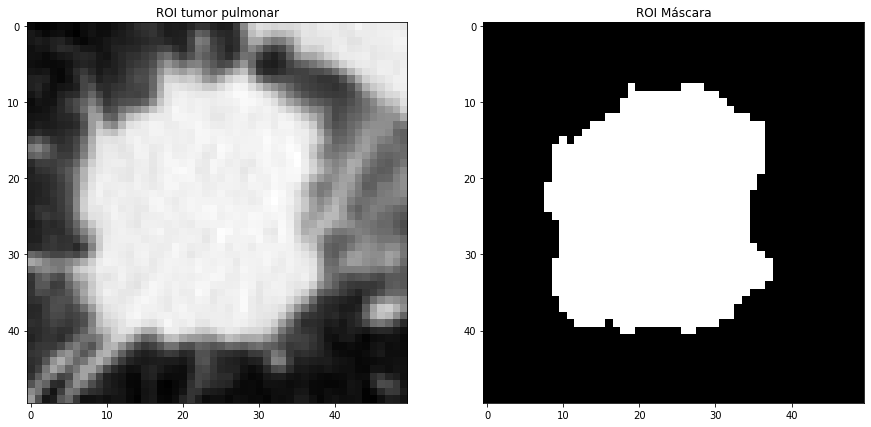

In [42]:
imagen = 15

f = plt.figure(figsize=(15,15))

f.add_subplot(1, 2, 1)
plt.title('ROI tumor pulmonar')
plt.imshow(show_slice_window(all_img[imagen], level,window_width), cmap='gray')


f.add_subplot(1, 2, 2)
plt.title('ROI Máscara')
plt.imshow(all_mask[imagen], cmap='gray')

plt.show()

## Representación volumétrica del tumor pulmonar

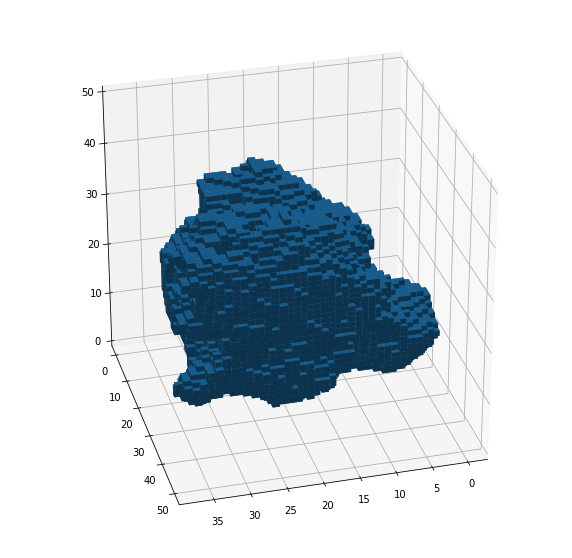

In [43]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(all_mask, edgecolor=None, cmap='viridis')

angulo_elevacion = 30
angulo_rotacion = 75

ax.view_init(angulo_elevacion, angulo_rotacion)
plt.show()

Volumen en pixeles de imagen segmentada por radiólogo: 19521
Volumen en pixeles de imagen procesada: 11191
Diferencia porcentual: 42.67 %


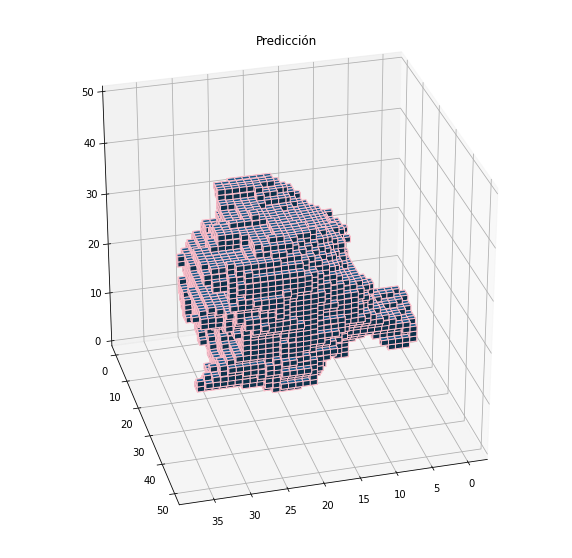

In [44]:
seg_procesada = np.copy(all_mask)

## Se define un kernel 
kernel = np.ones((5,5))

prediccion_volumetrica = cv2.erode(seg_procesada, kernel) 
  
## Comparación de los volumenes

print("Volumen en pixeles de imagen segmentada por radiólogo:", all_mask.sum())
print("Volumen en pixeles de imagen procesada:", prediccion_volumetrica.sum())
print("Diferencia porcentual:", round(((all_mask.sum() - prediccion_volumetrica.sum()) /all_mask.sum())*100,2), '%'  )


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plt.title('Predicción')

ax.voxels(prediccion_volumetrica, edgecolor='pink', cmap='viridis')

angulo_elevacion = 30
angulo_rotacion = 75

ax.view_init(angulo_elevacion, angulo_rotacion)

plt.show()

## Diferencia simétrica de distancia promedio a la superficie (ASSD)

Mide la distancia entre la superficie de la predicción respecto al Ground Truth. En el ejemplo, tenemos un tumor pulmonar en el cual el volumen de la predicción es similar al del Ground Truth. Sin embargo, existe un leve desplazamiento hacia el exterior de la lesión en algunas zonas de la predicción. Esta diferencia de distancia la captura la ASSD.
Sin embargo, como ocurre en otras métricas de distancia si la lesión está subsegmentada o sobresegmentada, el resultado es similar.

$ ASSD = \frac{ \sum_{x} \in X^{d,X}  + \sum_{y} \in Y^{d,Y}  } {|X| + |Y| }$


En la imagen podemos ver la diferencia entre la predicción, en este caso
 mas pequeña que el tumor verdadero


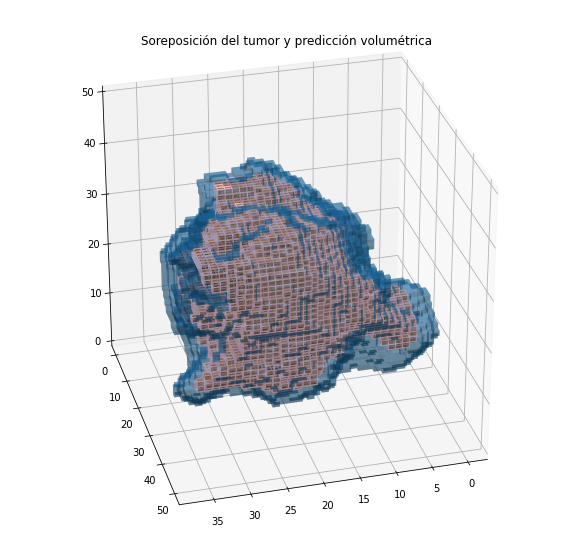

In [46]:

angulo_elevacion = 30
angulo_rotacion = 75

print("En la imagen podemos ver la diferencia entre la predicción, en este caso\n mas pequeña que el tumor verdadero")

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
plt.title('Soreposición del tumor y predicción volumétrica')

ax.voxels(all_mask, edgecolor=None, cmap='viridis', alpha=0.4)
ax.voxels(prediccion_volumetrica, edgecolor='pink', cmap='viridis', alpha=0.4)

ax.view_init(angulo_elevacion, angulo_rotacion)

plt.show()


* Utilizaremos la librería seg_metrics para realizar unos cálculos de distancia a superficie en este caso.
* En este caso nos da como métrica msd, que corresponde a la distancia de superficie promedio, junto con otras métricas de interés.

In [48]:
import seg_metrics.seg_metrics as sg

labels = [0, 1]

csv_file = 'metrics.csv'

metrics = sg.write_metrics(labels=labels[1:],  
                  gdth_img=all_mask,
                  pred_img=prediccion_volumetrica,
                  csv_file=csv_file,
                  metrics=['dice', 'hd', 'msd','vs'])
print(metrics)

1it [00:00,  8.67it/s]

[{'label': [1], 'dice': [0.7287704894252901], 'vs': [0.5424589736910653], 'hd': [4.582575798034668], 'msd': [1.6011240720685027]}]


## Conclusiones:
La segmentación de imágenes médicas se ha convertido en un área de gran utilidad con múltiples aplicaciones.
Es muy relevante conocer las diferentes métricas de evaluación, sus usos y desventajas. La evaluación de problemas de segmentación frecuentemente se realiza con la combinación de diferentes métricas y priorización de ellas según el problema.

## Bibliografía

* 1. Müller, D., Soto-Rey, I. & Kramer, F. Towards a guideline for evaluation metrics in medical image segmentation. BMC Res Notes 15, 210 (2022). https://doi.org/10.1186/s13104-022-06096-y
* 2. Taha, A.A., Hanbury, A. Metrics for evaluating 3D medical image segmentation: analysis, selection, and tool. BMC Med Imaging 15, 29 (2015). 
* 3. Yeghiazaryan V, Voiculescu I. Family of boundary overlap metrics for the evaluation of medical image segmentation. J Med Imaging (Bellingham). 2018 Jan;5(1):015006. doi: 10.1117/1.JMI.5.1.015006. Epub 2018 Feb 19. PMID: 29487883; PMCID: PMC5817231.